# TODO What is this file for

## Load General Dependencies

In [1]:
# Autoreload is not strictly necessary
# but helpful for development purposes
# as it automates the reload of python files
%load_ext autoreload
%autoreload 2

In [3]:
import json
import time
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np

from src import loading

## Load Mutation Dataset

In [27]:
data = loading.load_dataset('../TestingBackend/data/flask_full.pkl')

## Load Test.json
Because the version of the mutation testing dataset and the current repository version can be different,
a current output of pytest in json format is used to keep both in sync:

It can be simply generated by
``` TODO ```

Currently this is done by matching the name of the tests.

In [6]:
# Load into tests
with open('../flask/report.json') as file:
    parsed_json = json.load(file)
    tests = parsed_json['report']['tests']

In [28]:
test_full_names = []
for test in tests:
    test_full_names.append(test['name'])

def filter_nonexistent_tests(data, full_names):
    length = len(data)
    filtered_data = data[data['full_name'].isin(full_names)]
    filtered_length = len(filtered_data)
    print(f"Filtered for full names. Deleted {length - filtered_length} entries ({(length-filtered_length) / length * 100}%)")
    return filtered_data

data = filter_nonexistent_tests(data, test_full_names)

Filtered for full names. Deleted 26656 entries (2.7823443881838044%)


In [29]:
name_and_number_of_failures = data.groupby(['outcome', 'full_name']).count().loc['outcome' == False]['mutant_id']

In [30]:
# Store Mutant Failures in tests
for test in tests:
    test['mutant_failures'] = 0
    if test['name'] in name_and_number_of_failures:
        test['mutant_failures'] = int(name_and_number_of_failures.at[test['name']])

## Train Prediction Model

In [37]:
# Load additional Dependencies
from src import preprocessing
from sklearn import tree

In [38]:
# Apply preprocessing steps to make sure data does not contain invalid information
preprocessing.cleanse_data(data)
preprocessing.add_edit_distance_feature(data)
data = preprocessing.filter_NaN_values('flask', data)

flask: Kicked out 0 values from 931385 total values. (0.0%) (NaN value filter)


In [39]:
#encoded_column_names = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]
encoded_column_names = ["modified_file_path"]
dangerous_features = ['duration', 'setup_outcome', 'setup_duration', 'call_outcome', 'call_duration', 'teardown_outcome', 'teardown_duration']
unencoded_features = ['repo_path', 'full_name']

In [40]:
# Use a DecisionTreeClassifier
predictor = tree.DecisionTreeClassifier()

In [41]:
selected_features = [
    # Required Features (necessary for process)
    'test_id', 'outcome', 'mutant_id',
    
    # Basic features:
    #'current_line',
    'modified_file_path', 'line_number_changed',
    #'name', 'filepath', 'mutant_id', 'outcome',
    
    # Semantic features:
    #'modified_method', 'edit_distance',
    
    # Context features:
    #'contains_branch_mutant',
    #'contains_equality_comparison_mutant', 'contains_loop_mutant',
    #'contains_math_operands_mutant', 'contains_loop_execution', 'contains_math_operands_execution',
    #'contains_equality_comparison_execution', 'contains_branch_execution'
]

encoded_data, encoder = preprocessing.encode_columns(data, encoded_column_names)

encoded_data = encoded_data.drop(dangerous_features, axis=1).drop(unencoded_features, axis=1)[selected_features].copy()
   
X_train, y_train, X_test, y_test = preprocessing.train_test_split(encoded_data)
predictor.fit(X_train.drop(['mutant_id'],axis=1), y_train)

print("Score: " + str(predictor.score(X_test.drop(['mutant_id'], axis=1), y_test)))

Score: 0.9073799297149551


## Store files to disk

In [18]:
# JSON
with open('test_visualization_data.json', 'w') as file:
    json.dump(tests, file)

In [ ]:
# Joblib Files (Predictor Model)
joblib.dump({'predictor': predictor, 'encoder': encoder, 'test_ids_to_test_names': data.groupby('test_id').sample().set_index('test_id')['full_name']}, 'flask_decisiontree.joblib')

# Embedding from Covariances

In [55]:
# Load additional Dependencies
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap

In [64]:
def compute_and_show_embedding(model, data):
    pivot = data.set_index('mutant_id').pivot(columns='test_id', values='outcome')
    pivot = pivot.astype('bool')

    embedding = model.fit_transform(pivot.cov())
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.axis('equal')
    return embedding, pivot

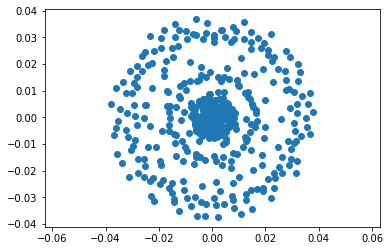

In [65]:
# MDS Embedding Model
embedding, pivot = compute_and_show_embedding(MDS(n_components=2, dissimilarity='precomputed', random_state=42), data)

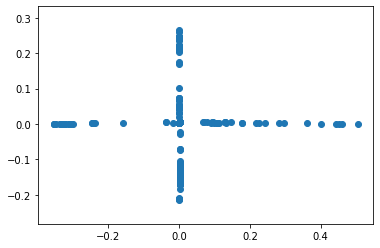

In [70]:
# ISOMap Embedding Model
embedding, pivot = compute_and_show_embedding(Isomap(n_components=2), data)

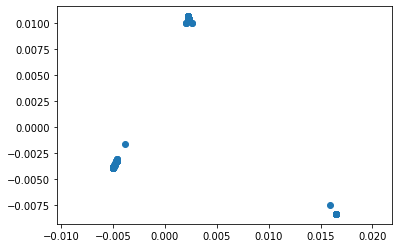

In [72]:
# Spectral Embedding Model
embedding, pivot = compute_and_show_embedding(SpectralEmbedding(n_components=2), data)

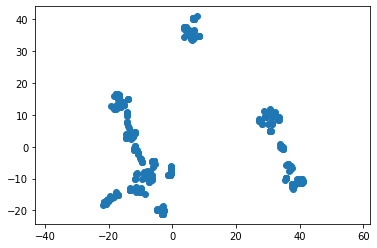

In [73]:
# TSNE Embedding Model
embedding, pivot = compute_and_show_embedding(TSNE(n_components=2, random_state=42), data)

In [17]:
# Store the xy coordinates of the embedding in `tests`
# Which model is used is dependent on which cell of the embeddings get's executed last
xy = pd.DataFrame(embedding, index=list(pivot.columns))
for test in tests:
    if test['name'] in xy.index:
        test['x'] = float(xy.at[test['name'], 0])
        test['y'] = float(xy.at[test['name'], 1])

# TF-IDF

In [6]:
test_failures = data.loc[data['outcome'] == False]

# Filebased approach: TF
tf = np.log( 1 + test_failures.groupby(['name', 'modified_file_path']).count()['mutant_id'])
# Filebased approach: IDF
N = len(data.groupby('filepath'))
print(N)

idf_counts = test_failures.groupby(['name']).count()['mutant_id']
print(idf_counts.value_counts())
idf = np.log(1 + N / idf_counts)
idf_counts

tfidf_analysis = pd.DataFrame(idf_counts.rename("overall_failures")).join(idf.rename("idf")).join(tf.rename("tf"))
tfidf_analysis['filename_failures'] = test_failures.groupby(['name', 'modified_file_path']).count()['mutant_id']
tfidf_analysis['tfidf'] = tfidf_analysis['tf'] * tfidf_analysis['idf']

18
72      25
1       15
182     15
147     13
2047    12
        ..
104      1
106      1
110      1
194      1
427      1
Name: mutant_id, Length: 178, dtype: int64


2877


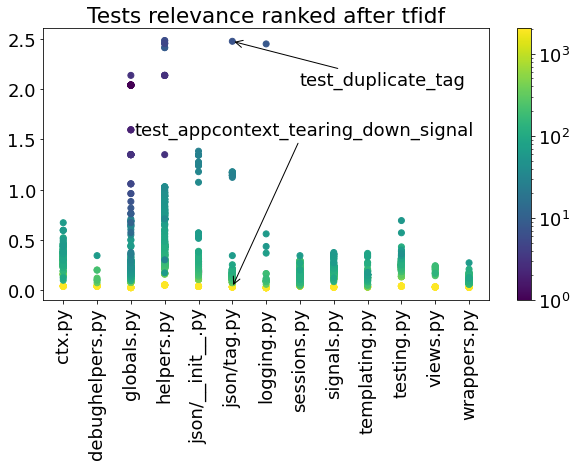

In [119]:
import matplotlib

matplotlib.rcParams.update({'font.size': 18})
# Distributions of test relevancies (absolute) between the different filepathes
file_paths = list(tfidf_analysis.groupby(['modified_file_path']).count().index)
file_paths_without_prefix = list(map(lambda s: s.removeprefix('src/flask/'), list(tfidf_analysis.groupby(['modified_file_path']).count().index)))
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev * 0.4

tfidf_analysis['filepath'] = list(map(lambda path: file_paths.index(path), list(y.index.get_level_values(1))))

tfidf_analysis = tfidf_analysis.loc[tfidf_analysis['filepath'] >= 0].sort_values('overall_failures', ascending=False)

y = tfidf_analysis['tfidf']

print(len(y))
x = tfidf_analysis['filepath'] 

figsize = (10, 5)
plt.figure(figsize=figsize)
plt.scatter(x, y, c=tfidf_analysis['overall_failures'], cmap='viridis', norm=matplotlib.colors.LogNorm())


plt.xticks(np.arange(len(file_paths)), file_paths_without_prefix, rotation='vertical')
plt.colorbar()
plt.title("Tests relevance ranked after tfidf")
ax = plt.gca()

ax.annotate('test_duplicate_tag',
            xy=(test_duplicate_tag.filepath, test_duplicate_tag.tfidf), xycoords='data', horizontalalignment='left', verticalalignment='bottom',
            xytext=(7, 2), textcoords='data',
            arrowprops=dict(arrowstyle= '->'))

ax.annotate('test_appcontext_tearing_down_signal',
            xy=(test_appcontext.filepath, test_appcontext.tfidf), xycoords='data', horizontalalignment='left', verticalalignment='bottom',
            xytext=(2.1, 1.5), textcoords='data',
            arrowprops=dict(arrowstyle= '->'))

plt.savefig("tfidf.png", dpi=1000, bbox_inches = 'tight')
plt.show()


In [83]:
test_duplicate_tag = tfidf_analysis.loc['test_duplicate_tag', 'src/flask/json/tag.py']
test_appcontext = tfidf_analysis.loc['test_appcontext_tearing_down_signal', 'src/flask/json/tag.py']

2877


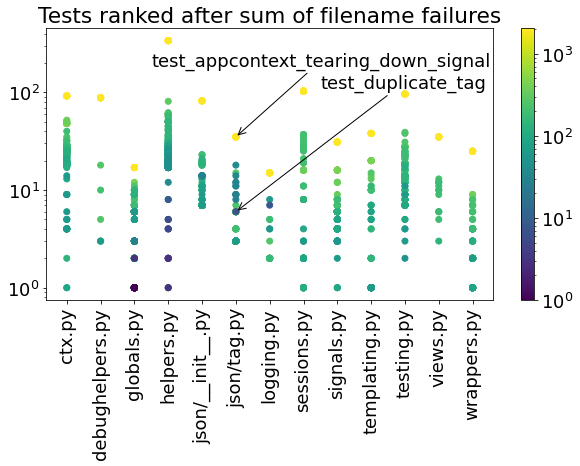

In [123]:
# Distributions of test relevancies (absolute) between the different filepathes


plt.figure(figsize=figsize)
ax = plt.gca()
ax.set_yscale('log')

tfidf_analysis = tfidf_analysis.sort_values('overall_failures', ascending=False)
y = tfidf_analysis['filename_failures']
print(len(y))
x = list(map(lambda path: file_paths.index(path), list(y.index.get_level_values(1))))
plt.scatter(x, y, c=tfidf_analysis['overall_failures'], cmap='viridis', norm=matplotlib.colors.LogNorm())


plt.xticks(np.arange(len(file_paths)), file_paths_without_prefix, rotation='vertical')
plt.colorbar()
plt.title("Tests ranked after sum of filename failures")


ax.annotate('test_duplicate_tag',
            xy=(test_duplicate_tag.filepath, test_duplicate_tag.filename_failures), xycoords='data', horizontalalignment='left', verticalalignment='bottom',
            xytext=(7.5, 100), textcoords='data',
            arrowprops=dict(arrowstyle= '->'))

ax.annotate('test_appcontext_tearing_down_signal',
            xy=(test_appcontext.filepath, test_appcontext.filename_failures), xycoords='data', horizontalalignment='left', verticalalignment='bottom',
            xytext=(2.5, 170), textcoords='data',
            arrowprops=dict(arrowstyle= '->'))


plt.savefig("filename_failures.png", dpi=1000, bbox_inches = 'tight')
plt.show()

In [79]:
tfidf

name                                                 modified_file_path   
TestGenericHandlers::test_handle_class_or_code[500]  src/flask/app.py         4.371334
                                                     src/flask/config.py      1.270249
                                                     src/flask/ctx.py         2.985364
                                                     src/flask/globals.py     1.783019
                                                     src/flask/helpers.py     2.985364
                                                                                ...   
test_wsgi_errors_stream                              src/flask/logging.py     1.641773
                                                     src/flask/sessions.py    2.013297
                                                     src/flask/signals.py     1.783019
                                                     src/flask/testing.py     2.418144
                                                     sr